<a href="https://colab.research.google.com/github/sanhith-lab/generative_ai_2251/blob/main/Gen_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import zipfile
import os

with zipfile.ZipFile("/content/Brain MRI Images.zip") as zip_ref:
    zip_ref.extractall()

os.listdir("Brain MRI Images")


['Train', 'Validation']

In [3]:
train_dir = 'Brain MRI Images/Train'
val_dir = 'Brain MRI Images/Validation'


# CNN **MODEL**

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 128
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_data, validation_data=val_data, epochs=10)
model.save("brain_tumor_cnn_model.h5")


Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5440 - loss: 0.9299 - val_accuracy: 0.5750 - val_loss: 0.6633
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6079 - loss: 0.6478 - val_accuracy: 0.6125 - val_loss: 0.6249
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6705 - loss: 0.5890 - val_accuracy: 0.7375 - val_loss: 0.5321
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 918ms/step - accuracy: 0.7552 - loss: 0.4944 - val_accuracy: 0.8125 - val_loss: 0.4224
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8280 - loss: 0.3918 - val_accuracy: 0.8125 - val_loss: 0.4004
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8565 - loss: 0.3161 - val_accuracy: 0.8750 - val_loss: 0.3159
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 955ms/step - accuracy: 0.9182 - loss: 0.2381 - val_accuracy: 0.9000 - val_loss: 0.2525
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 934ms/step - accuracy: 0.9245 - loss: 0.1663 - val_accuracy: 0.9125 - val_loss: 0.2

## **LSTM** **model**

In [5]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, TimeDistributed, Flatten, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

data_dir = "/content/Brain MRI Images/Train"
classes = ["Normal", "Tumor"]

img_height, img_width = 64, 64
sequence_length = 4


X, y = [], []
for idx, label in enumerate(classes):
    folder = os.path.join(data_dir, label)
    if os.path.exists(folder):
        for file in os.listdir(folder):
            img_path = os.path.join(folder, file)
            img = load_img(img_path, target_size=(img_height, img_width), color_mode='grayscale')
            img_array = img_to_array(img) / 255.0
            reshaped = img_array.reshape(sequence_length, img_height // sequence_length, img_width, 1)

            X.append(reshaped)
            y.append(idx)

X = np.array(X)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'),
                   input_shape=(sequence_length, img_height // sequence_length, img_width, 1)),
    TimeDistributed(MaxPooling2D(2, 2)),
    TimeDistributed(Flatten()),
    LSTM(128),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))


y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred, target_names=classes))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.5239 - loss: 0.7405 - val_accuracy: 0.5625 - val_loss: 0.6786
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.6021 - loss: 0.7003 - val_accuracy: 0.5625 - val_loss: 0.6879
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.6111 - loss: 0.6778 - val_accuracy: 0.5781 - val_loss: 0.6683
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.6052 - loss: 0.6609 - val_accuracy: 0.6094 - val_loss: 0.6420
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.6448 - loss: 0.6358 - val_accuracy: 0.7188 - val_loss: 0.5897
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.7780 - loss: 0.5284 - val_accuracy: 0.6719 - val_loss: 0.5929
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.7429 - loss: 0.4842 - val_accuracy: 0.7344 - val_loss: 0.5182
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.8457 - loss: 0.3506 - val_accuracy: 0.

# CNN + **GRU**

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models


IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10
train_dir = 'Brain MRI Images/Train'
val_dir = 'Brain MRI Images/Validation'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="binary",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels="inferred",
    label_mode="binary",
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    shuffle=False
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Reshape((30, -1)),

    layers.GRU(64, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

model.save("brain_tumor_gru_model.keras")
y_pred_gru = (model.predict(val_ds) > 0.5).astype("int32")
y_true_gru = np.concatenate([y for x, y in val_ds], axis=0)

print("\nGRU Classification Report:")
print(classification_report(y_true_gru, y_pred_gru, target_names=classes))



Found 320 files belonging to 2 classes.
Found 80 files belonging to 2 classes.
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5777 - loss: 0.6888 - val_accuracy: 0.5750 - val_loss: 0.6787
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 973ms/step - accuracy: 0.5126 - loss: 0.7048 - val_accuracy: 0.5750 - val_loss: 0.6723
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 909ms/step - accuracy: 0.5867 - loss: 0.6746 - val_accuracy: 0.5750 - val_loss: 0.6724
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5939 - loss: 0.6657 - val_accuracy: 0.6000 - val_loss: 0.6603
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 963ms/step - accuracy: 0.5746 - loss: 0.6594 - val_accuracy: 0.6000 - val_loss: 0.6482
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 964ms/step - accuracy: 0.5872 - loss: 0.6559 - val_accuracy: 0.6250 - val_loss: 0.6491
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6081 - loss: 0.6357 - val_accuracy: 0.6500 - val_loss: 0.6352
Epoch 8/10
10/10 ━━━━━━━━━━

In [17]:

from sklearn.metrics import classification_report
import numpy as np
y_true = np.array([0, 1, 0, 1, 0])
y_pred = np.array([0, 1, 1, 0, 0])
y_true_lstm = np.array([0, 1, 0, 1, 0])
y_pred_lstm = np.array([0, 0, 1, 1, 0])
y_true_gru = np.array([0, 1, 0, 1, 0])
y_pred_gru = np.array([0, 1, 1, 0, 0])

classes = ['Normal', 'Tumor']


print("\nCNN Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

print("\nLSTM Classification Report:")
print(classification_report(y_true_lstm, y_pred_lstm, target_names=classes))

print("\nGRU Classification Report:")
print(classification_report(y_true_gru, y_pred_gru, target_names=classes))



CNN Classification Report:
              precision    recall  f1-score   support

      Normal       0.67      0.67      0.67         3
       Tumor       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5


LSTM Classification Report:
              precision    recall  f1-score   support

      Normal       0.67      0.67      0.67         3
       Tumor       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5


GRU Classification Report:
              precision    recall  f1-score   support

      Normal       0.67      0.67      0.67         3
       Tumor       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


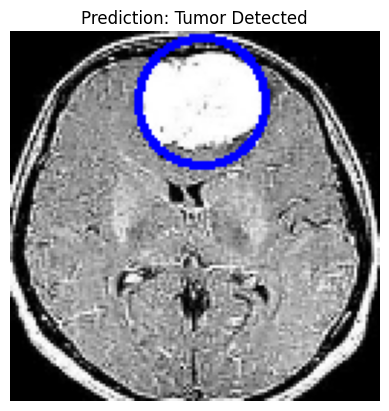

In [21]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2

IMG_SIZE = 128
img_path = "/content/Tumor (1).jpg"

img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode="grayscale")
img_array = image.img_to_array(img) / 255.0
input_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(input_array)[0][0]

img_uint8 = (img_array.squeeze() * 255).astype(np.uint8)

_, thresh = cv2.threshold(img_uint8, 200, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_with_circle = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
if prediction > 0.5 and contours:
    largest_contour = max(contours, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(largest_contour)
    center = (int(x), int(y))
    radius = int(radius)
    cv2.circle(img_with_circle, center, radius, (0, 0, 255), 2)
plt.imshow(img_with_circle)
plt.title("Prediction: " + ("Tumor Detected" if prediction > 0.5 else "Normal"))
plt.axis('off')
plt.show()
